Imports and plotting function:

In [27]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import random

%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) is torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(data.T[0, pos_idx], data.T[1, pos_idx], 'r^', label='positive')
    ax.plot(data.T[0, neg_idx], data.T[1, neg_idx], 'bo', label='negative')
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min() - 1, features[:, 0].max() + 1
    min2, max2 = features[:, 1].min() - 1, features[:, 1].max() + 1
    return (min1, max1, min2, max2)


def plot_decision_regions(features,
                          targets,
                          model,
                          axis=None,
                          transform=None,
                          bounds=None,
                          title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1, r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    grid = np.insert(grid, 0, 1.0, axis=1)

    # generate predictions over grid
    yhat = model(torch.from_numpy(grid).float()).detach().numpy()

    pred = np.argmax(yhat, axis=1)

    # reshape the predictions back into a grid
    zz = pred.reshape(xx.shape)

    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(features[row_idx_neg, 0],
                 features[row_idx_neg, 1],
                 label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(features[row_idx_pos, 0],
                 features[row_idx_pos, 1],
                 label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

Set random seed and read data function:

In [28]:
np.random.seed(42)
torch.manual_seed(0)

def read_data(name, mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root, name, mode)

    i = 0
    with open(filename, 'rt') as f:
        for line in f:
            line = line.replace('\n', '')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0, x1, x2])
                y_data.append([y])
                temp = [0, 0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data, dtype='float32')
    ys = np.array(y_data, dtype='float32')
    labels = np.array(label_data, dtype='float32')
    return (xs, ys, labels)

Setting up the neural network:

In [29]:
# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a custom dataset class
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, name, mode):
        self.x_data, self.y_data, self.labels = read_data(name, mode)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_data[idx], dtype=torch.float32)
        y = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return x, y


# Define the neural network
class net3(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, activation):
        super(net3, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)  # input to hidden layer
        self.l2 = nn.Linear(hidden_size, output_size)  # hidden to output layer
        self.activation = activation  # define the activation function

    def forward(self, x):
        output = self.l1(x)
        output = self.activation(output)
        output = self.l2(output)
        #a = torch.mul(x[:,1],x[:,1])
        #b = torch.mul(x[:,2],x[:,2])
        #c = (a+b)/9.0
        #output = torch.exp(c)
        
        return output

Training and testing functions:

In [30]:
# training function
def train(model, data_loader, loss_function, optimizer):

    model.train()
    train_loss = 0  # for plotting learning curves for training and validation loss as a function of training epochs

    for batch, (X, y) in enumerate(data_loader):
        
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_function(pred, y.squeeze().long())  # Originally y.unsqueeze(1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f"Pred: {pred[:5]}")
        #print(f"Y: {y[:5]}")
        #print(f"Loss: {loss.item()}")
        train_loss += loss.item()

    train_loss /= len(data_loader)
    return train_loss


# testing function
def test(model, data_loader, loss_function):

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_function(pred, y.squeeze().long()).item()  # Originally y.unsqueeze(1)
            test_loss += loss

    test_loss /= len(data_loader)
    return test_loss

Accuracy and learning curves:

In [31]:
# output the final accuracy of the model
def final_accuracy(model, data_loader):

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = nn.functional.softmax(pred, dim=1)
            pred = torch.round(pred)
            if (pred[0,0] == 1 and y == 0) or (pred[0, 1] == 1 and y == 1):
                correct_predictions += 1
                
            total_predictions += y.size(0)

    return correct_predictions / total_predictions


def plot_training_and_validation_loss(train_loss, test_loss):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1,
                   len(train_loss) + 1),
             train_loss,
             label="Training Loss",
             marker='o')
    plt.plot(range(1,
                   len(test_loss) + 1),
             test_loss,
             label="Validation Loss",
             linestyle="--",
             marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(
        "Learning curves for training and validation loss as a function of training epochs"
    )
    plt.legend()
    plt.grid(True)
    plt.ion()
    plt.show()

In [32]:
def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min() - 1, features[:, 0].max() + 1
    min2, max2 = features[:, 1].min() - 1, features[:, 1].max() + 1
    return (min1, max1, min2, max2)


def plot_decision_regions(features,
                          targets,
                          model,
                          axis=None,
                          transform=None,
                          bounds=None,
                          title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1, r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    grid = np.insert(grid, 0, 1.0, axis=1)

    # generate predictions over grid
    yhat = model(torch.from_numpy(grid).float()).detach().numpy()

    x = 0

    if yhat.shape[1] == 1: # XXX
        yhat = np.hstack((yhat, 1 - yhat))
        x = 1
    
    pred = np.argmax(yhat, axis=1)

    # reshape the predictions back into a grid
    zz = pred.reshape(xx.shape)

    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])

    if x == 1:
        binary_cmap = matplotlib.colors.ListedColormap(['#ffc773', '#9ce8ff'])

    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(features[row_idx_neg, 0],
                 features[row_idx_neg, 1],
                 label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(features[row_idx_pos, 0],
                 features[row_idx_pos, 1],
                 label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

Part 1:
Hyperparameters used:
    input_size = 3
    output_size = 2
    learning_rate = 0.01
    num_epochs = 100
    batch_size = 10

cost function = multi-class cross entropy

Running the model to find the best k and test accuracy for each dataset:

In [33]:
# hyperparameters
input_size = 3
output_size = 2
learning_rate = 0.01
num_epochs = 100
batch_size = 10

# Part 1
activation_function = nn.ReLU()
loss_function = nn.CrossEntropyLoss()

# Part 2
#activation_function = nn.Sigmoid()
#loss_function = nn.MSELoss()

# possible values
hidden_sizes = [2, 3, 5, 7, 9]
names = ['xor', 'two_gaussians', 'spiral', 'center_surround']

# to store best k and values for each dataset as well as losses
best_ks = [0, 0, 0, 0]
best_accs = [0, 0, 0, 0]
best_train_loss = [[], [], [], []]
best_valid_loss = [[], [], [], []]
best_models_1 = [[], [], [], []]

# iterate through each name and hidden size
for ii, name in enumerate(names):
    best_k = 0
    best_acc = 0

    for hidden_size in hidden_sizes:

        # initialize loss lists
        train_loss = []
        valid_loss = []

        # define the datasets and the loaders
        train_dataset = CustomDataset(name, 'train')
        valid_dataset = CustomDataset(name, 'valid')
        test_dataset = CustomDataset(name, 'test')

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, 1, shuffle=False)

        # build the model and optimizer
        model = net3(input_size, hidden_size, output_size, activation_function)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # train the model
        for epoch in range(num_epochs):
            train_losses = train(model, train_loader, loss_function, optimizer)
            valid_losses = test(model, valid_loader, loss_function)
            train_loss.append(train_losses)
            valid_loss.append(valid_losses)

        # Update best k/accuracy if needed
        final_acc = final_accuracy(model, test_loader)
        if final_acc > best_acc:
            best_acc = final_acc
            best_k = hidden_size

            best_accs[ii] = best_acc
            best_ks[ii] = best_k

            best_train_loss[ii] = train_loss
            best_valid_loss[ii] = valid_loss

            best_models_1[ii] = model

Plot the learning curves for the best k in each dataset, and provide the final test accuracy, as well as the learned decision surface:

Best accuracy on test set for name = "xor" is with k = 5, and it reaches a value of 0.99



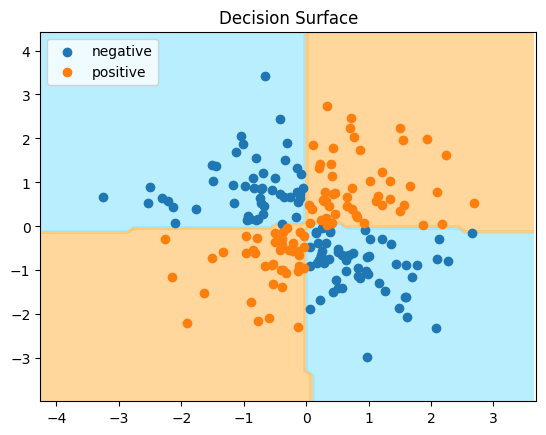

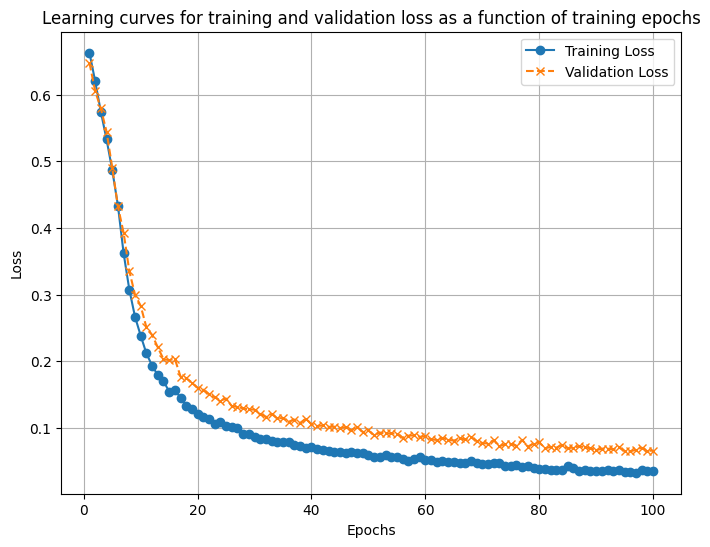






Best accuracy on test set for name = "two_gaussians" is with k = 2, and it reaches a value of 0.92



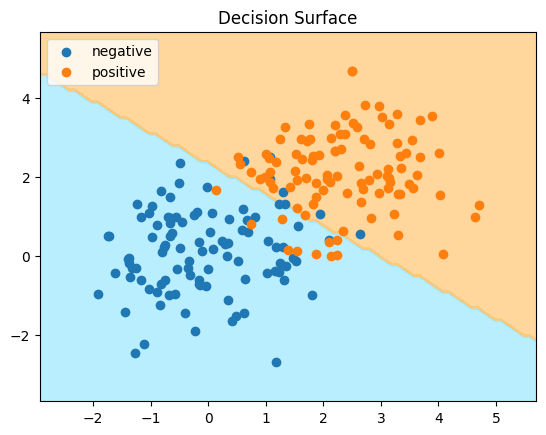

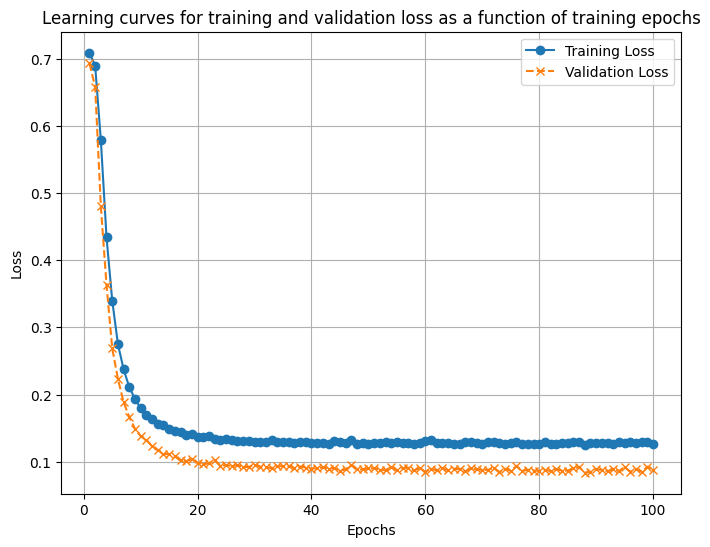






Best accuracy on test set for name = "spiral" is with k = 9, and it reaches a value of 1.00



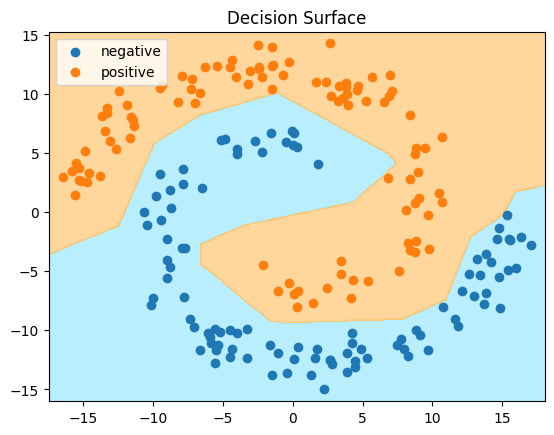

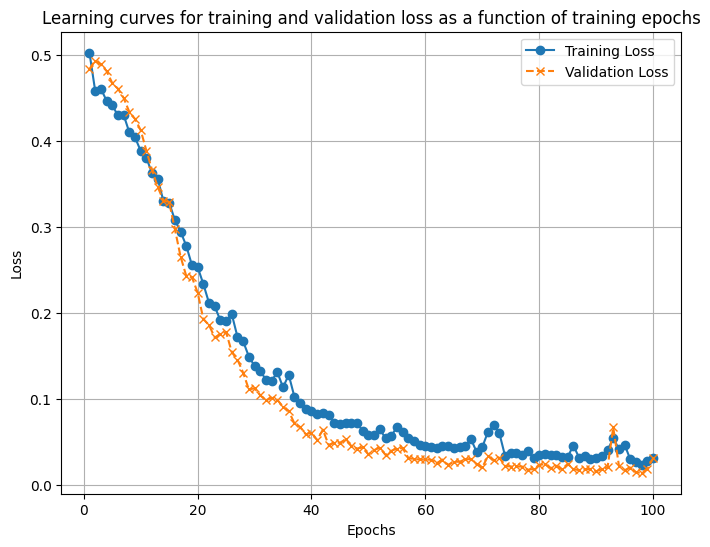






Best accuracy on test set for name = "center_surround" is with k = 3, and it reaches a value of 0.75



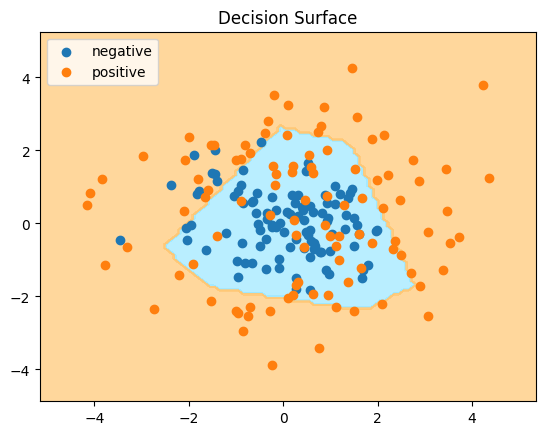

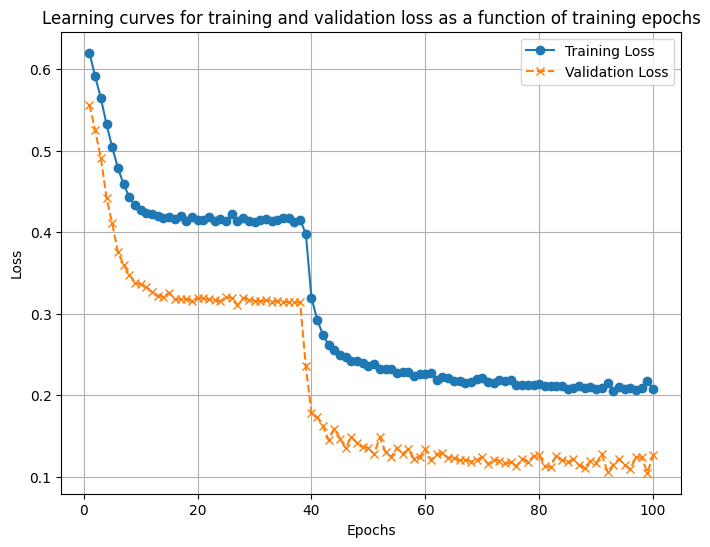

In [34]:
for ii, kk in enumerate(best_ks):

    print('Best accuracy on test set for name = "%s" is with k = %i, and it reaches a value of %.2f\n' % (names[ii], best_ks[ii], best_accs[ii]))

    x_vals, targets, _ = read_data(names[ii], 'test')
    features = np.array([inner_list[1:] for inner_list in x_vals])

    plot_decision_regions(features, targets, best_models_1[ii])

    # plot the train loss and test loss against the number of epochs in seperate graphs
    plot_training_and_validation_loss(best_train_loss[ii], best_valid_loss[ii])

    print("\n")

    print("\n\n")

Part 2: Redefine train, test, and final accuracy functions

In [38]:
# training function
def train(model, data_loader, loss_function, optimizer):

    model.train()
    train_loss = 0  # for plotting learning curves for training and validation loss as a function of training epochs

    for batch, (X, y) in enumerate(data_loader):
        
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_function(pred, y.float())  # Originally y.squeeze().float()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f"Pred: {pred[:5]}")
        #print(f"Y: {y[:5]}")
        #print(f"Loss: {loss.item()}")
        train_loss += loss.item()

    train_loss /= len(data_loader)
    return train_loss


# testing function
def test(model, data_loader, loss_function):

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_function(pred, y.float()).item()  # Originally y.squeeze().float()
            test_loss += loss

    test_loss /= len(data_loader)
    return test_loss

# output the final accuracy of the model
def final_accuracy(model, data_loader):

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = torch.round(pred)

            if pred == y:
                correct_predictions += 1
                
            total_predictions += y.size(0)

    return correct_predictions / total_predictions

Part 2:
Hyperparameters used:
    input_size = 3
    output_size = 1
    learning_rate = 0.0001
    num_epochs = 150
    batch_size = 10

cost function = mean-squared error

Running the model to find the best k and test accuracy for each dataset:

In [41]:
# hyperparameters
input_size = 3
output_size = 1
learning_rate = 0.0001
num_epochs = 300
batch_size = 10

# Part 1
#activation_function = nn.ReLU()
#loss_function = nn.CrossEntropyLoss()

# Part 2
activation_function = nn.Sigmoid()
loss_function = nn.MSELoss()

# possible values
hidden_sizes = [2, 3, 5, 7, 9]
names = ['xor', 'two_gaussians', 'spiral', 'center_surround']

# to store best k and values for each dataset as well as losses
best_ks = [0, 0, 0, 0]
best_accs = [0, 0, 0, 0]
best_train_loss = [[], [], [], []]
best_valid_loss = [[], [], [], []]
best_models_2 = [[], [], [], []]

# iterate through each name and hidden size
for ii, name in enumerate(names):
    best_k = 0
    best_acc = 0

    for hidden_size in hidden_sizes:

        # initialize loss lists
        train_loss = []
        valid_loss = []

        # define the datasets and the loaders
        train_dataset = CustomDataset(name, 'train')
        valid_dataset = CustomDataset(name, 'valid')
        test_dataset = CustomDataset(name, 'test')

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, 1, shuffle=False)

        # build the model and optimizer
        model = net3(input_size, hidden_size, output_size, activation_function)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # train the model
        for epoch in range(num_epochs):
            train_losses = train(model, train_loader, loss_function, optimizer)
            valid_losses = test(model, valid_loader, loss_function)
            train_loss.append(train_losses)
            valid_loss.append(valid_losses)

        # Update best k/accuracy if needed
        final_acc = final_accuracy(model, test_loader)
        if final_acc > best_acc:
            best_acc = final_acc
            best_k = hidden_size

            best_accs[ii] = best_acc
            best_ks[ii] = best_k

            best_train_loss[ii] = train_loss
            best_valid_loss[ii] = valid_loss

            best_models_2[ii] = model

Plot the learning curves for the best k in each dataset, and provide the final test accuracy, as well as the learned decision surface:

Best accuracy on test set for name = "xor" is with k = 7, and it reaches a value of 0.58



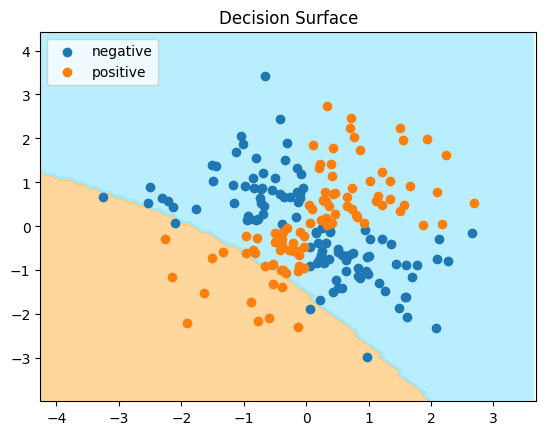

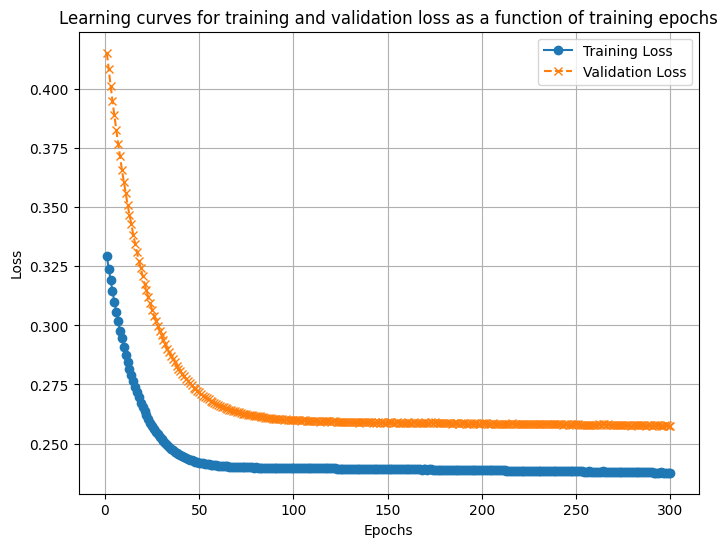






Best accuracy on test set for name = "two_gaussians" is with k = 5, and it reaches a value of 0.93



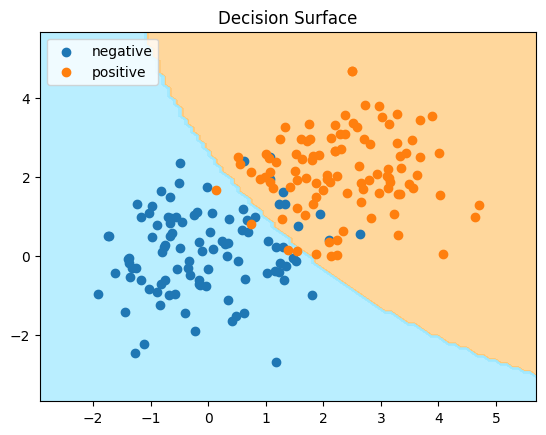

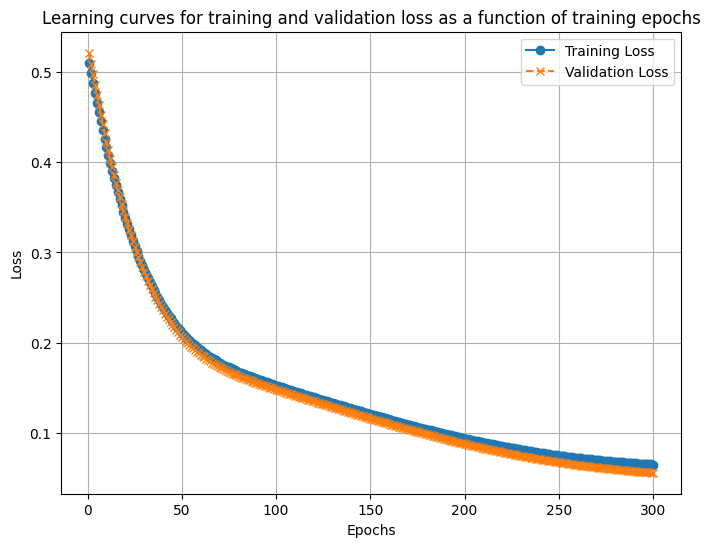






Best accuracy on test set for name = "spiral" is with k = 5, and it reaches a value of 0.81



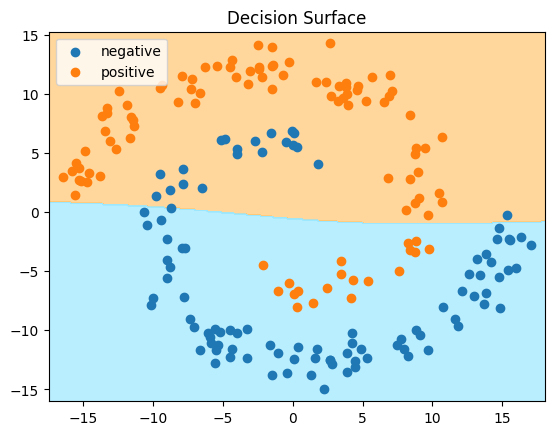

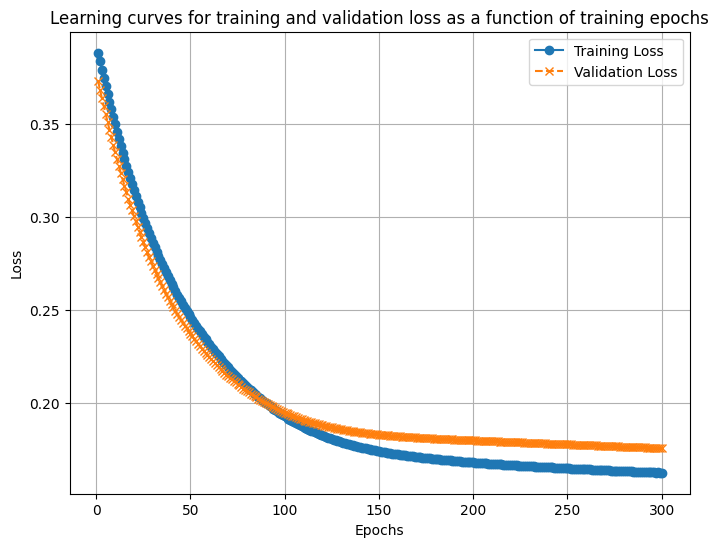






Best accuracy on test set for name = "center_surround" is with k = 5, and it reaches a value of 0.70



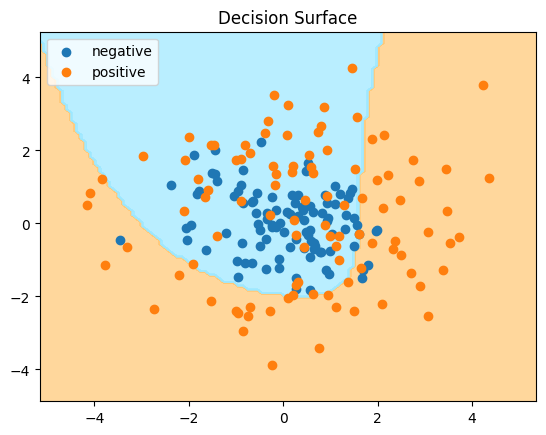

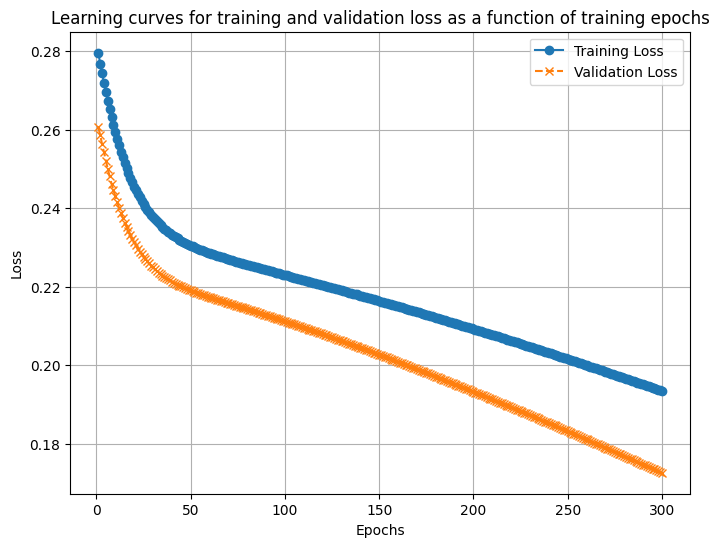

In [42]:
for ii, kk in enumerate(best_ks):

    print('Best accuracy on test set for name = "%s" is with k = %i, and it reaches a value of %.2f\n' % (names[ii], best_ks[ii], best_accs[ii]))

    x_vals, targets, _ = read_data(names[ii], 'test')
    features = np.array([inner_list[1:] for inner_list in x_vals])

    plot_decision_regions(features, targets, best_models_2[ii])

    # plot the train loss and test loss against the number of epochs in seperate graphs
    plot_training_and_validation_loss(best_train_loss[ii], best_valid_loss[ii])

    print("\n")

    print("\n\n")